In [ ]:
# load and split data

import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("../data/raw/fraud_transactions.csv")
X = df.drop('fraud_flag', axis=1)
y = df['fraud_flag']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# currency conversion
class CurrencyConverter(BaseEstimator, TransformerMixin):
    def __init__(self, rates=None, base_currency="INR"):
        if rates is None:
            rates = {"INR": 1.0, "USD": 83.0, "EUR": 90.0}
        self.rates = rates
        self.base_currency = base_currency

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X["amount_converted"] = X.apply(
            lambda row: row["amount"] * self.rates.get(row["currency"], 1.0), axis=1
        )
        return X
    
    def get_feature_names_out(self, input_features=None):
        """Add 'amount_converted' to the feature names"""
        if input_features is None:
            input_features = []
        # Return original features + new feature
        output_features = list(input_features) + ['amount_converted']
        return np.asarray(output_features, dtype=object)


# typo fixing   
class TypoFixer(BaseEstimator, TransformerMixin):
    def __init__(self, column='merchant_category', typo_map=None):
        if typo_map is None:
            typo_map = {'Groceires': 'Groceries'}
        self.column = column
        self.typo_map = typo_map
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        if self.column in X.columns:
            X[self.column] = X[self.column].replace(self.typo_map)
        return X
    
    def get_feature_names_out(self, input_features=None):
        """Feature names unchanged - just fixing typos"""
        if input_features is None:
            return np.array([self.column], dtype=object)
        return np.asarray(input_features, dtype=object)
    

# outlier clipping
class OutlierClipper(BaseEstimator, TransformerMixin):
    def __init__(self, features=None, lower_quantile=0.01, upper_quantile=0.99):
        self.features = features
        self.lower_quantile = lower_quantile
        self.upper_quantile = upper_quantile
        self.bounds = {}

    def fit(self, X, y=None):
        for col in self.features:
            q_low = X[col].quantile(self.lower_quantile)
            q_high = X[col].quantile(self.upper_quantile)
            self.bounds[col] = (q_low, q_high)
        return self

    def transform(self, X):
        X = X.copy()
        for col, (low, high) in self.bounds.items():
            X[col] = X[col].clip(lower=low, upper=high)
        return X
    
    def get_feature_names_out(self, input_features=None):
        """Feature names unchanged - just clipping values"""
        if input_features is None:
            return np.asarray(self.features, dtype=object)
        return np.asarray(input_features, dtype=object)
    

# Define Feature Groups
num_features = [
    "amount_converted", "velocity", "ip_risk_score", "customer_age",
    "account_tenure", "geo_distance", "merchant_risk_score", "failed_login_attempts"
]

cat_features = [
    "currency", "merchant_category", "transaction_type", "channel", "location"
]

bin_features = ["card_present", "is_international"]


# Pipelines for Each Feature Type

# Numerical pipeline
num_pipeline = Pipeline([
    ("outlier_clipper", OutlierClipper(features=num_features)),
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Categorical pipeline
cat_pipeline = Pipeline([
    ("typo_fixer", TypoFixer()),
    ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

cat_pipeline_catboost = Pipeline([
    ("typo fixer", TypoFixer()),
    ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown"))
])

# Binary pipeline
bin_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent"))
])


# Full Preprocessing Pipeline
preprocessor = Pipeline([
    ("currency_converter", CurrencyConverter()),
    ("transformer", ColumnTransformer([
        ("num", num_pipeline, num_features),
        ("cat", cat_pipeline, cat_features),
        ("bin", bin_pipeline, bin_features)
    ]))
])

preprocessor_catboost = Pipeline([
    ("currency_converter", CurrencyConverter()),
    ("transformer", ColumnTransformer([
        ("num", num_pipeline, num_features),
        ("cat", cat_pipeline_catboost, cat_features),
        ("bin", bin_pipeline, bin_features)
    ]))
])

In [3]:
from sklearn.base import BaseEstimator, ClassifierMixin
from catboost import CatBoostClassifier

class SklearnCatBoost(BaseEstimator, ClassifierMixin):
    def __init__(self, **kwargs):
        # Default parameters, can be overridden
        self.params = kwargs
        self.model = None

    def fit(self, X, y):
        self.model = CatBoostClassifier(**self.params)
        self.model.fit(X, y, verbose=0)
        return self

    def predict(self, X):
        return self.model.predict(X)

    def predict_proba(self, X):
        return self.model.predict_proba(X)

In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "Random Forest": RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=42),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss", scale_pos_weight=10, random_state=42),
    "LightGBM": lgb.LGBMClassifier(class_weight="balanced", random_state=42, verbose=0),
    "AdaBoost": AdaBoostClassifier(n_estimators=200, random_state=42)
}

results = []

for name, model in models.items():
    clf = Pipeline([
        ("preprocessor", preprocessor),
        ("model", model)
    ])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:,1]

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_prob)
    })

# Handle CatBoost separately (preprocess data first, then train)
print("Training CatBoost...")
try:
    # Preprocess data outside pipeline
    X_trf = preprocessor_catboost.fit_transform(X_train)
    feature_names = preprocessor_catboost.named_steps["transformer"].get_feature_names_out()
    X_train_transformed = pd.DataFrame(X_trf, columns=feature_names)

    X_test_transformed = preprocessor_catboost.transform(X_test)
    
    catboost_features = [col for col in X_train_transformed.columns.tolist() if col.startswith("cat_")]

    # Train CatBoost on preprocessed data
    catboost_model = cb.CatBoostClassifier(
        verbose=0, 
        class_weights=[1, 10], 
        random_state=42,
        cat_features=[X_train_transformed.columns.get_loc(col) for col in catboost_features]
    )
    catboost_model.fit(X_train_transformed, y_train)
    y_pred_cb = catboost_model.predict(X_test_transformed)
    y_prob_cb = catboost_model.predict_proba(X_test_transformed)[:, 1]
    
    results.append({
        "Model": "CatBoost",
        "Accuracy": accuracy_score(y_test, y_pred_cb),
        "Precision": precision_score(y_test, y_pred_cb, zero_division=0),
        "Recall": recall_score(y_test, y_pred_cb, zero_division=0),
        "F1": f1_score(y_test, y_pred_cb, zero_division=0),
        "ROC-AUC": roc_auc_score(y_test, y_prob_cb)
    })
except Exception as e:
    print(f"CatBoost failed: {e}")

# clf_catboost = Pipeline([
#     ("preprocessor for catboost", preprocessor_catboost),
#     ("model", SklearnCatBoost(class_weights=[1,10], random_state=42, iterations=500, verbose=0, depth=6, learning_rate=0.1))
# ])
# clf_catboost.fit(X_train, y_train)
# y_pred_cb = clf_catboost.predict(X_test)
# y_prob_cb = clf_catboost.predict_proba(X_test)[:,1]

# results.append({
#     "Model": "CatBoost",
#     "Accuracy": accuracy_score(y_test, y_pred_cb),
#     "Precision": precision_score(y_test, y_pred_cb),
#     "Recall": recall_score(y_test, y_pred_cb),
#     "F1": f1_score(y_test, y_pred_cb),
#     "ROC-AUC": roc_auc_score(y_test, y_prob_cb)
# })

import pandas as pd
results_df = pd.DataFrame(results)
print(results_df.sort_values(by="ROC-AUC", ascending=False))

d:\Projects\Fraud Detection\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [18:36:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\Projects\Fraud Detection\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
d:\Projects\Fraud Detection\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training CatBoost...
                 Model  Accuracy  Precision    Recall        F1   ROC-AUC
1        Random Forest   0.99045   1.000000  0.464986  0.634799  0.741114
0  Logistic Regression   0.90645   0.098621  0.521008  0.165849  0.738201
3             LightGBM   0.98170   0.486880  0.467787  0.477143  0.730299
2              XGBoost   0.98920   0.869110  0.464986  0.605839  0.730145
4             AdaBoost   0.98800   0.782609  0.453782  0.574468  0.728405
5             CatBoost   0.99020   0.970760  0.464986  0.628788  0.721126


In [25]:
X_trf = preprocessor_catboost.fit_transform(X_train)
feature_names = preprocessor_catboost.named_steps["transformer"].get_feature_names_out()
X_train_transformed = pd.DataFrame(X_trf, columns=feature_names)


# catboost_features = X_train_transformed.select_dtypes(include=["object", "category"]).columns.tolist()

#extract categorical feature names
catboost_features = [col for col in X_train_transformed.columns.tolist() if col.startswith("cat_")]
print(catboost_features)
print([X_train_transformed.columns.get_loc(col) for col in catboost_features])
X_train_transformed.head()

['cat__currency', 'cat__merchant_category', 'cat__transaction_type', 'cat__channel', 'cat__location']
[8, 9, 10, 11, 12]


,num__amount_converted,num__velocity,num__ip_risk_score,num__customer_age,num__account_tenure,num__geo_distance,num__merchant_risk_score,num__failed_login_attempts,cat__currency,cat__merchant_category,cat__transaction_type,cat__channel,cat__location,bin__card_present,bin__is_international
0,0.257367,-1.003394,0.242062,0.300494,-0.620696,-0.953741,-0.362128,-0.456485,USD,Travel,Online,Mobile,Bangalore,1,0
1,-0.509897,1.971939,-0.815649,-1.363474,0.374139,2.724618,0.460154,-0.456485,INR,Electronics,POS,Mobile,Delhi,1,0
2,-0.500988,-1.003394,-0.436805,-0.49821,-1.366823,-0.986539,0.103911,-0.456485,INR,Groceries,Online,Mobile,Delhi,1,0
3,-0.503909,-0.011616,0.816178,-0.697887,-0.869405,0.146315,1.361101,-0.456485,INR,Travel,POS,Web,Bangalore,1,0
4,-0.508043,-0.011616,0.069974,-0.831004,0.622848,-0.673583,0.684904,-0.456485,INR,Travel,POS,Web,Bangalore,1,1



MODEL COMPARISON RESULTS
              Model  Accuracy  Precision   Recall       F1  ROC-AUC
Logistic Regression   0.90645   0.098621 0.521008 0.165849 0.738201
      Random Forest   0.99045   1.000000 0.464986 0.634799 0.741114
            XGBoost   0.98920   0.869110 0.464986 0.605839 0.730145
           LightGBM   0.98170   0.486880 0.467787 0.477143 0.730299
           AdaBoost   0.98800   0.782609 0.453782 0.574468 0.728405
           CatBoost   0.99040   0.994012 0.464986 0.633588 0.735820


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_32148\790041411.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_sorted, x=metric, y="Model", ax=ax, palette="viridis")
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_32148\790041411.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_sorted, x=metric, y="Model", ax=ax, palette="viridis")
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_32148\790041411.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_sorted, x=metric, y="Model", ax=ax, palette="viridis")
C

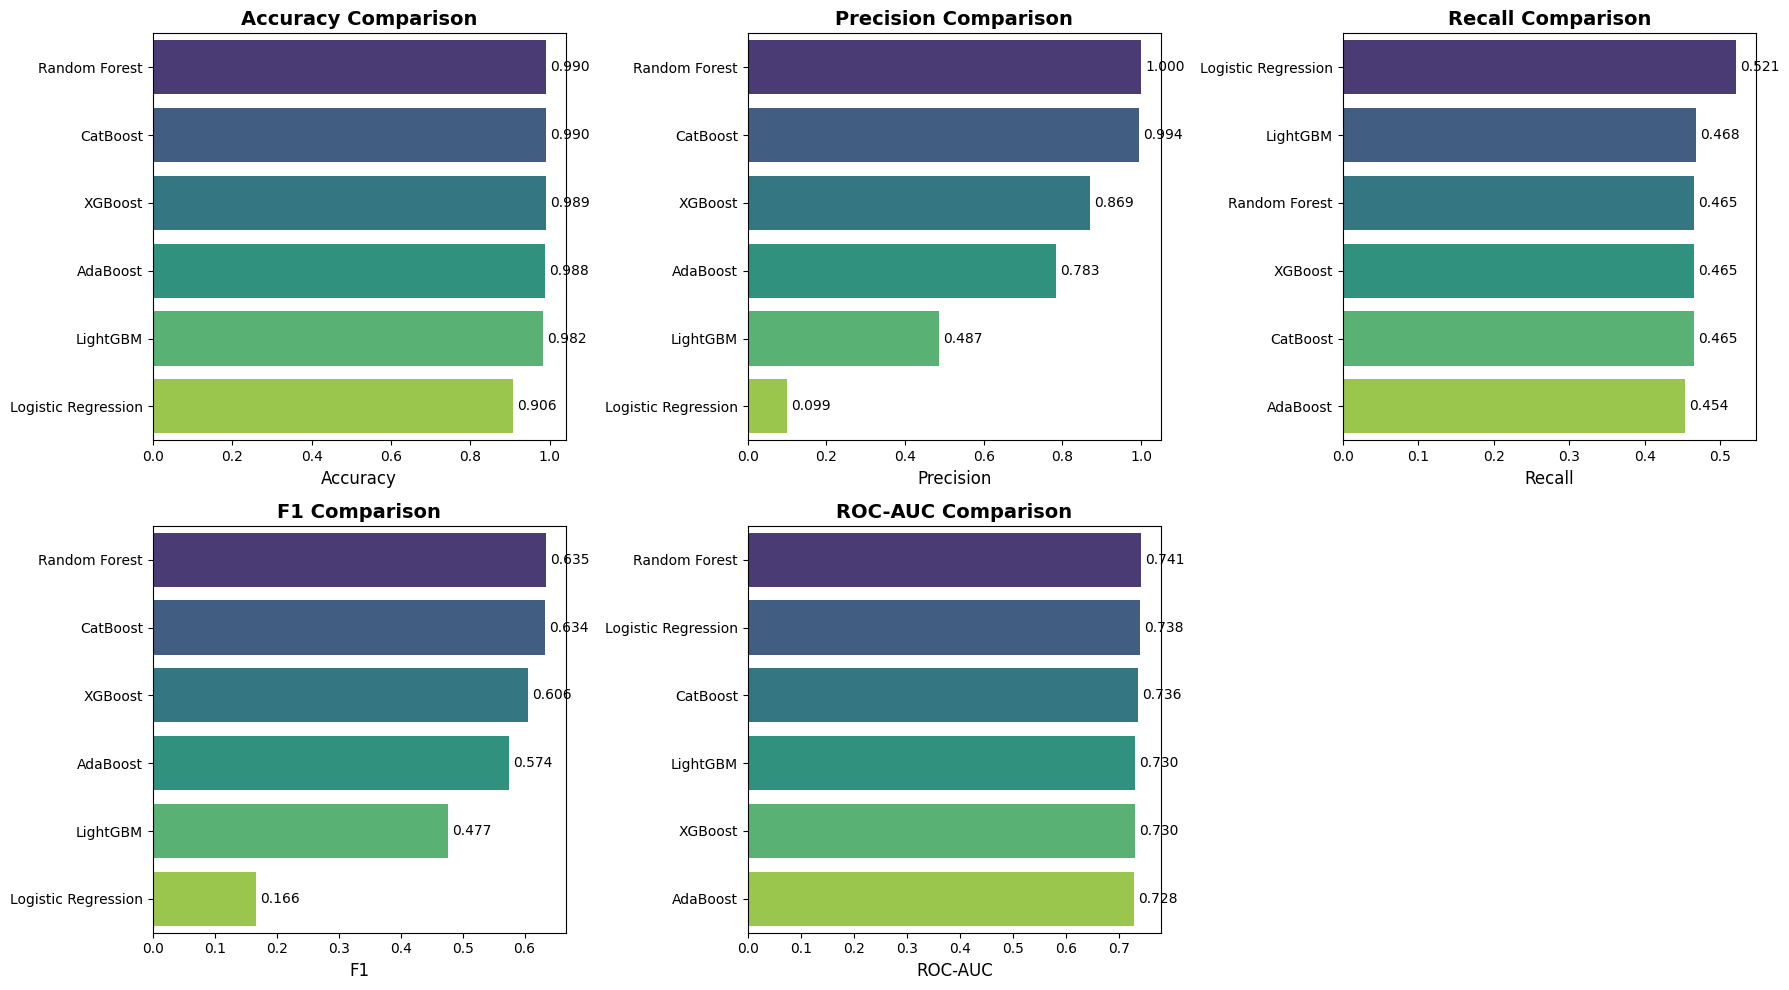


BEST MODELS BY METRIC
Accuracy    : Random Forest        (0.9905)
Precision   : Random Forest        (1.0000)
Recall      : Logistic Regression  (0.5210)
F1          : Random Forest        (0.6348)
ROC-AUC     : Random Forest        (0.7411)


In [5]:
print("\n" + "="*80)
print("MODEL COMPARISON RESULTS")
print("="*80)
print(results_df.to_string(index=False))

# Visualize results
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
metrics = ["Accuracy", "Precision", "Recall", "F1", "ROC-AUC"]

for idx, metric in enumerate(metrics):
    ax = axes[idx // 3, idx % 3]
    results_sorted = results_df.sort_values(by=metric, ascending=False)
    
    sns.barplot(data=results_sorted, x=metric, y="Model", ax=ax, palette="viridis")
    ax.set_title(f'{metric} Comparison', fontsize=14, fontweight='bold')
    ax.set_xlabel(metric, fontsize=12)
    ax.set_ylabel('')
    
    # Add value labels
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', padding=3)

# Hide the last subplot
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

# Print best model for each metric
print("\n" + "="*80)
print("BEST MODELS BY METRIC")
print("="*80)
for metric in metrics:
    best_model = results_df.loc[results_df[metric].idxmax()]
    print(f"{metric:12s}: {best_model['Model']:20s} ({best_model[metric]:.4f})")
